In [1]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation, CLIPSegModel

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
model = model.to(device)

In [4]:
COLOR_MAP = dict({
    # 'background': (0, 0, 0),
    'ship': (0, 0, 63),
    'storage tank': (0, 191, 127),
    'baseball diamond': (0, 63, 0),
    'tennis court': (0, 63, 127),
    'basketball court': (0, 63, 191),
    'ground track field': (0, 63, 255),
    'bridge': (0, 127, 63),
    'large vehicle': (0, 127, 127),
    'small vehicle': (0, 0, 127),
    'helicopter': (0, 0, 191),
    'swimming pool': (0, 0, 255),
    'roundabout': (0, 63, 63),
    'soccer ball field': (0, 127, 191),
    'plane': (0, 127, 255),
    'harbor': (0, 100, 155),
})

prompts = list(COLOR_MAP.keys())
class_num = len(prompts)
color = torch.tensor(list(COLOR_MAP.values()), dtype=torch.uint8).to(device)
threshold = 0.3

In [17]:
def get_pred(image_ori, debug=0):  
  final_pred = torch.zeros((class_num, int(np.ceil(image_ori.height/352)*352), int(np.ceil(image_ori.width/352)*352))).to(device)
  for w_start in range(0, image_ori.width, 352):
    for h_start in range(0, image_ori.height, 352):
      image = image_ori.crop((w_start, h_start, 352+w_start, 352+h_start))
      inputs = processor(text=prompts, images=[image] * class_num, padding="max_length", return_tensors="pt")
      inputs = inputs.to(device)
      # predict
      with torch.no_grad():
        outputs = model(**inputs)
      # visualize prediction
      preds = outputs.logits
      final_pred[:, h_start:h_start+352, w_start:w_start+352] = preds
      if not debug:
        continue
      display(image)
      _, ax = plt.subplots(1, class_num+1, figsize=(20, 20))
      [a.axis('off') for a in ax.flatten()]
      ax[0].imshow(image_ori)
      p = preds.sigmoid()
      for i in range(class_num):
          res = p[i]
          ax[i+1].imshow(res)
      [ax[i+1].text(0, -15, prompts[i]) for i in range(class_num)];
      plt.show()
      prob, pred = p.max(dim=0)
      ans_map = color[pred]
      # 置信度低的标签为背景
      ans_map[prob<threshold] = 255
      img = Image.fromarray(ans_map.numpy(), mode='RGB')
      display(img)
  return final_pred.sigmoid()

In [19]:
image_path = 'isaid_segm/val/images/images/P0003.png'
image_ori = Image.open(image_path)
final_pred = get_pred(image_ori)

输出mask与原图的混合

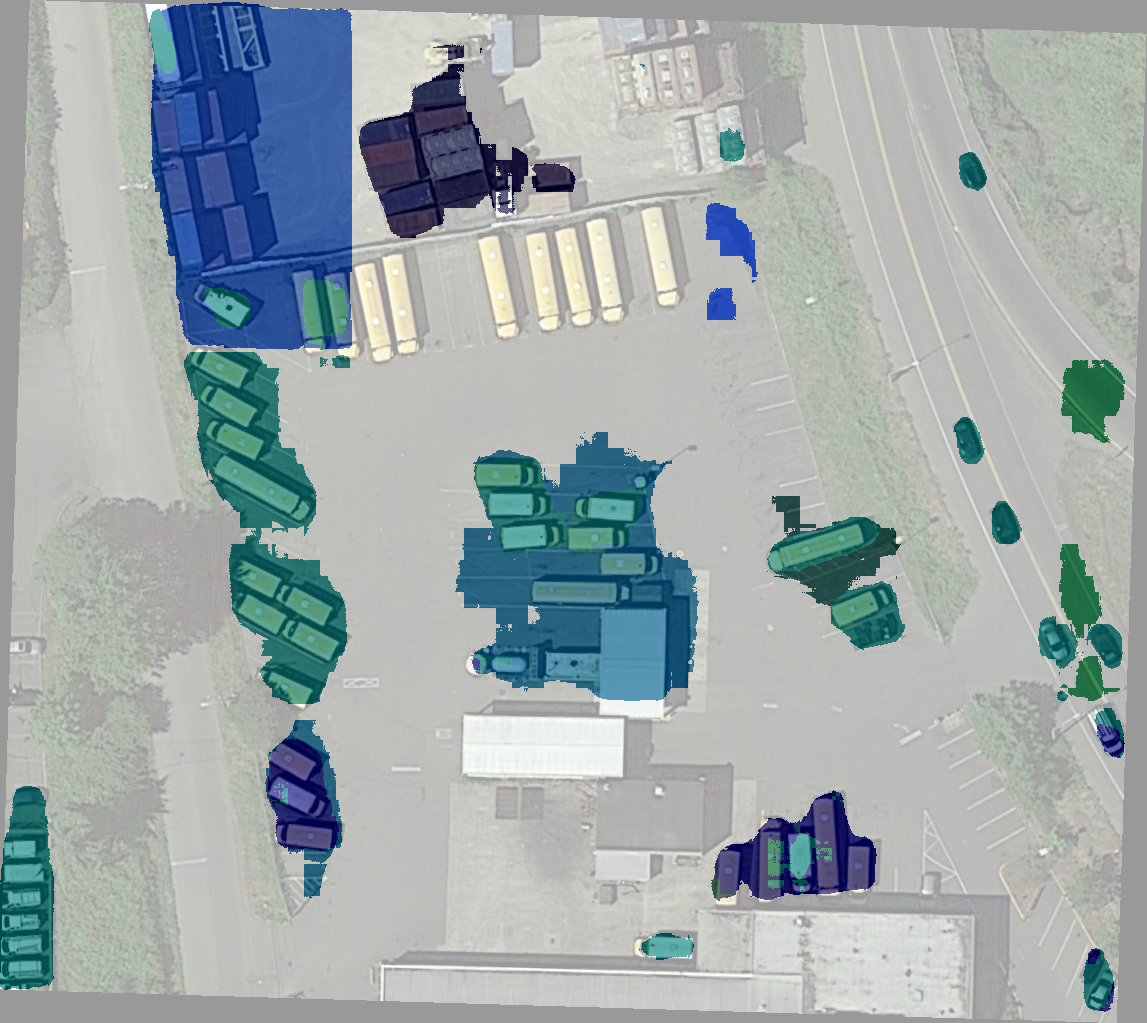

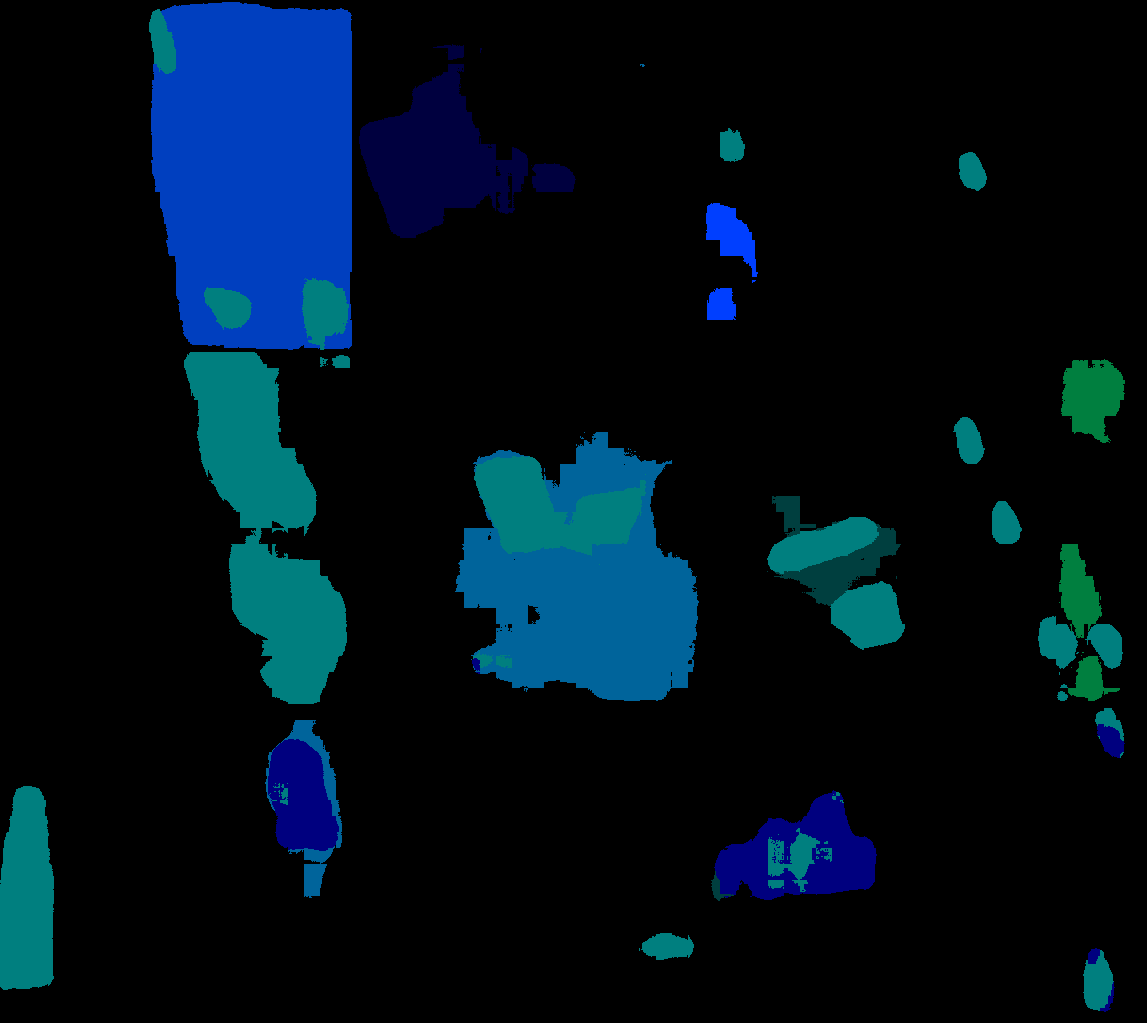

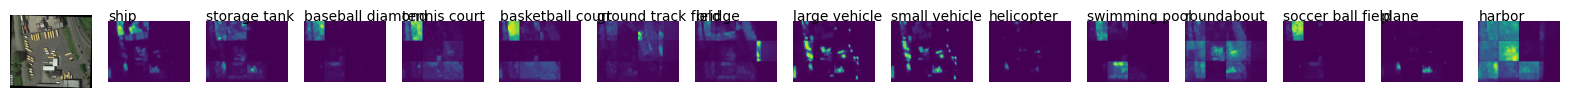

In [22]:
# visualize prediction
def vis(final_pred, prompts, threshold_list = [0.3]):
    class_num = len(prompts)

    _, ax = plt.subplots(1, class_num+1, figsize=(20, 20))
    [a.axis('off') for a in ax.flatten()]
    ax[0].imshow(image_ori)
    for i in range(class_num):
        ax[i+1].imshow(final_pred[i].cpu())
    [ax[i+1].text(0, -15, prompts[i]) for i in range(class_num)];
    prob, pred = final_pred.max(dim=0)
    # 置信度低的标签为背景

    for threshold in threshold_list:
        ans_map = color[pred].clone()
        ans_map[prob<threshold] = 255
        img = Image.fromarray(ans_map.cpu().numpy(), mode='RGB')
        img = img.crop((0, 0, image_ori.width, image_ori.height))
        display(Image.blend(image_ori, img, 0.6))
    
    for threshold in threshold_list:
        ans_map = color[pred].clone()
        ans_map[prob<threshold] = 0
        img = Image.fromarray(ans_map.cpu().numpy(), mode='RGB')
        img = img.crop((0, 0, image_ori.width, image_ori.height))
        display(Image.blend(image_ori, img, 1))
vis(final_pred, prompts)

